In [1]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
# import geopandas

load_dotenv()

cities_list = pd.read_excel('cities_list.xlsx')

API_KEY = os.getenv('API_KEY')

def get_air_pollution_data(API_KEY, lat, lon):
    url = f'http://api.openweathermap.org/data/2.5/air_pollution/forecast?lat={lat}&lon={lon}&appid={API_KEY}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error requisition: {response.status_code}')
        return None

In [2]:
cities_list

,name,lon,lat,country
0,Abidjan,-4.00167,5.35444,Ivory Coast
1,Abu Dhabi,54.39696,24.45118,United Arab Emirates
2,Abuja,7.49508,9.05785,Nigeria
3,Accra,-0.19690,5.55602,Ghana
4,Addis Ababa,38.74689,9.02497,Ethiopia
...,...,...,...,...
366,Yaounde,11.51667,3.86667,Cameroon
367,Yekaterinburg,60.61220,56.85190,Russia
368,Yerevan,44.51361,40.18111,Armenia
369,Yokohama,139.65000,35.43333,Japan


In [3]:
def process_pollution_data(data, city, country):
    if not data or 'list'not in data:
        return None
    
    formatted_data = []
    for item in data['list']:
        row = {
            'dt': item['dt'],
            'aqi': item['main']['aqi'],
            'city': city,
            'country': country,
            'co': item['components']['co'],
            'no': item['components']['no'],
            'no2': item['components']['no2'],
            'o3': item['components']['o3'],
            'so2': item['components']['so2'],
            'pm2_5': item['components']['pm2_5'],
            'pm10': item['components']['pm10'],
            'nh3': item['components']['nh3']

        }
        if isinstance(item.get('components'), dict):
            row.update(item['components'])
            if 'coord' in item:
                row['lon'] = item['coord'].get('lon', None)
                row['lat'] = item['coord'].get('lat', None)
        formatted_data.append(row)
        
    return formatted_data

In [4]:
def format_date(timestamp):
    if pd.isna(timestamp):
        return None
    elif isinstance(timestamp, (int, float)):
        return pd.to_datetime(timestamp, unit='s')
    return None

In [5]:
all_data = []
for index, row in cities_list.iterrows():
    lon = row['lon']
    lat = row['lat']
    country = row['country']
    city = row['name']
    data = get_air_pollution_data(API_KEY, lat, lon)
    
    if data:
        city_data = process_pollution_data(data, city, country)
        if city_data:
            all_data.append(city_data)

In [6]:
correction_data = [item for sublist in all_data for item in sublist if isinstance(item, dict)]
df = pd.DataFrame(correction_data)

In [7]:
df['dt'] = df['dt'].apply(format_date)

In [8]:
df

,dt,aqi,city,country,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2025-06-09 02:00:00,1,Abidjan,Ivory Coast,111.88,0.0,0.15,39.77,0.14,2.35,3.47,0.01
1,2025-06-09 03:00:00,1,Abidjan,Ivory Coast,113.02,0.0,0.16,40.36,0.13,2.29,3.35,0.01
2,2025-06-09 04:00:00,1,Abidjan,Ivory Coast,113.56,0.0,0.17,40.71,0.13,2.36,3.47,0.01
3,2025-06-09 05:00:00,1,Abidjan,Ivory Coast,113.77,0.0,0.18,40.80,0.14,2.45,3.66,0.01
4,2025-06-09 06:00:00,1,Abidjan,Ivory Coast,113.45,0.0,0.21,40.67,0.14,2.50,3.76,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
35611,2025-06-12 21:00:00,2,Zagreb,Croatia,268.04,0.0,2.17,93.36,0.62,6.60,7.09,2.38
35612,2025-06-12 22:00:00,2,Zagreb,Croatia,264.59,0.0,2.21,84.22,0.52,6.57,7.05,2.37
35613,2025-06-12 23:00:00,2,Zagreb,Croatia,262.41,0.0,2.22,74.94,0.43,6.58,7.06,2.34
35614,2025-06-13 00:00:00,2,Zagreb,Croatia,259.99,0.0,2.06,67.91,0.36,6.56,7.03,2.25


In [9]:
df['dt']

0       2025-06-09 02:00:00
1       2025-06-09 03:00:00
2       2025-06-09 04:00:00
3       2025-06-09 05:00:00
4       2025-06-09 06:00:00
                ...        
35611   2025-06-12 21:00:00
35612   2025-06-12 22:00:00
35613   2025-06-12 23:00:00
35614   2025-06-13 00:00:00
35615   2025-06-13 01:00:00
Name: dt, Length: 35616, dtype: datetime64[ns]

In [10]:
df['aqi'] = df['aqi'].astype(int)

In [11]:
df = df.drop('aqi', axis=1)

In [12]:
df.query('(city == "Abidjan")')

,dt,city,country,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2025-06-09 02:00:00,Abidjan,Ivory Coast,111.88,0.0,0.15,39.77,0.14,2.35,3.47,0.01
1,2025-06-09 03:00:00,Abidjan,Ivory Coast,113.02,0.0,0.16,40.36,0.13,2.29,3.35,0.01
2,2025-06-09 04:00:00,Abidjan,Ivory Coast,113.56,0.0,0.17,40.71,0.13,2.36,3.47,0.01
3,2025-06-09 05:00:00,Abidjan,Ivory Coast,113.77,0.0,0.18,40.80,0.14,2.45,3.66,0.01
4,2025-06-09 06:00:00,Abidjan,Ivory Coast,113.45,0.0,0.21,40.67,0.14,2.50,3.76,0.01
...,...,...,...,...,...,...,...,...,...,...,...
91,2025-06-12 21:00:00,Abidjan,Ivory Coast,104.34,0.0,0.20,46.08,0.09,1.67,2.44,0.00
92,2025-06-12 22:00:00,Abidjan,Ivory Coast,101.97,0.0,0.16,46.19,0.09,1.48,2.19,0.00
93,2025-06-12 23:00:00,Abidjan,Ivory Coast,99.34,0.0,0.15,46.42,0.08,1.50,2.17,0.00
94,2025-06-13 00:00:00,Abidjan,Ivory Coast,96.97,0.0,0.14,46.77,0.08,1.77,2.49,0.00


In [13]:
df['city'][29650]

'Sao Paulo'

In [14]:
df_sp = df[df['city'] == 'Sao Paulo']

In [15]:
df_sp

,dt,city,country,co,no,no2,o3,so2,pm2_5,pm10,nh3
29568,2025-06-09 02:00:00,Sao Paulo,Brazil,83.25,0.0,0.36,42.67,0.10,1.17,1.92,0.00
29569,2025-06-09 03:00:00,Sao Paulo,Brazil,80.59,0.0,0.28,43.76,0.09,1.09,1.90,0.00
29570,2025-06-09 04:00:00,Sao Paulo,Brazil,78.18,0.0,0.21,43.66,0.08,1.03,1.92,0.00
29571,2025-06-09 05:00:00,Sao Paulo,Brazil,76.57,0.0,0.17,42.74,0.08,0.98,2.02,0.01
29572,2025-06-09 06:00:00,Sao Paulo,Brazil,76.32,0.0,0.14,42.40,0.07,0.89,2.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...
29659,2025-06-12 21:00:00,Sao Paulo,Brazil,70.80,0.0,0.91,46.64,0.07,1.03,4.24,0.03
29660,2025-06-12 22:00:00,Sao Paulo,Brazil,70.45,0.0,0.96,46.21,0.07,1.03,4.42,0.03
29661,2025-06-12 23:00:00,Sao Paulo,Brazil,69.92,0.0,0.90,45.63,0.08,1.03,4.55,0.04
29662,2025-06-13 00:00:00,Sao Paulo,Brazil,69.80,0.0,0.79,44.57,0.10,1.04,4.59,0.05


In [18]:
df['city'].value_counts().unique

<bound method Series.unique of city
Hyderabad         192
Abidjan            96
Nuuk               96
Panama             96
Palo Alto          96
                 ... 
Gujranwala         96
Guayaquil          96
Guatemala City     96
Guangzhou          96
Zagreb             96
Name: count, Length: 370, dtype: int64>

In [19]:
df['country'].value_counts().unique

<bound method Series.unique of country
United States    2016
China            1152
Indonesia        1056
Brazil           1056
India            1056
                 ... 
Netherlands        96
Sudan              96
Rwanda             96
Jamaica            96
Croatia            96
Name: count, Length: 214, dtype: int64>

In [20]:
country_Components = df.groupby('country')[['co','no','no2','o3','so2','pm2_5','pm10','nh3']].mean()
country_Components

,co,no,no2,o3,so2,pm2_5,pm10,nh3
country,,,,,,,,
Afghanistan,170.146562,0.103750,1.298229,92.846563,0.299583,11.534896,31.389167,0.650312
Aland Islands,144.883125,0.363333,3.125729,68.190104,1.209479,2.942083,3.671875,0.120104
Albania,155.322604,0.183646,2.609271,105.541354,2.371146,17.084271,26.810000,1.119375
Algeria,110.533750,0.181562,3.075313,74.023333,0.629167,14.235312,45.118958,0.885104
American Samoa,65.923021,0.000000,0.016979,52.155625,0.102292,2.509688,11.746771,0.000000
...,...,...,...,...,...,...,...,...
Venezuela,153.410911,0.065911,1.582995,15.690417,0.164115,1.812448,1.993776,0.984010
Vietnam,575.281979,0.865208,10.347188,23.541146,2.614635,27.977240,30.889167,3.495313
Yemen,89.266667,0.071979,2.223646,81.081250,6.312188,46.545729,116.338958,1.879896


In [21]:
city_Components = df.groupby('city')[['co','no','no2','o3','so2','pm2_5','pm10','nh3']].mean()
city_Components

,co,no,no2,o3,so2,pm2_5,pm10,nh3
city,,,,,,,,
Abidjan,119.316354,0.006146,0.180417,48.053542,0.117604,2.029688,2.850729,0.001146
Abu Dhabi,133.378333,0.070729,1.657917,126.327396,1.943125,62.110833,269.873854,0.049271
Abuja,335.995417,0.076667,1.833437,23.984792,0.377500,14.499688,19.806250,0.956042
Accra,118.488542,0.004896,0.183125,47.250521,0.192396,2.231354,3.032604,0.001562
Addis Ababa,514.046771,0.100625,3.222604,46.140625,1.260104,36.173021,62.022812,6.248542
...,...,...,...,...,...,...,...,...
Yaounde,110.988437,0.069062,0.993854,9.485521,0.114479,1.721563,1.976146,0.034063
Yekaterinburg,104.140833,0.066771,0.791354,63.688958,1.044687,3.542917,3.791354,0.327396
Yerevan,90.740521,0.099375,1.472083,72.306146,0.265729,2.188438,4.063438,4.207813


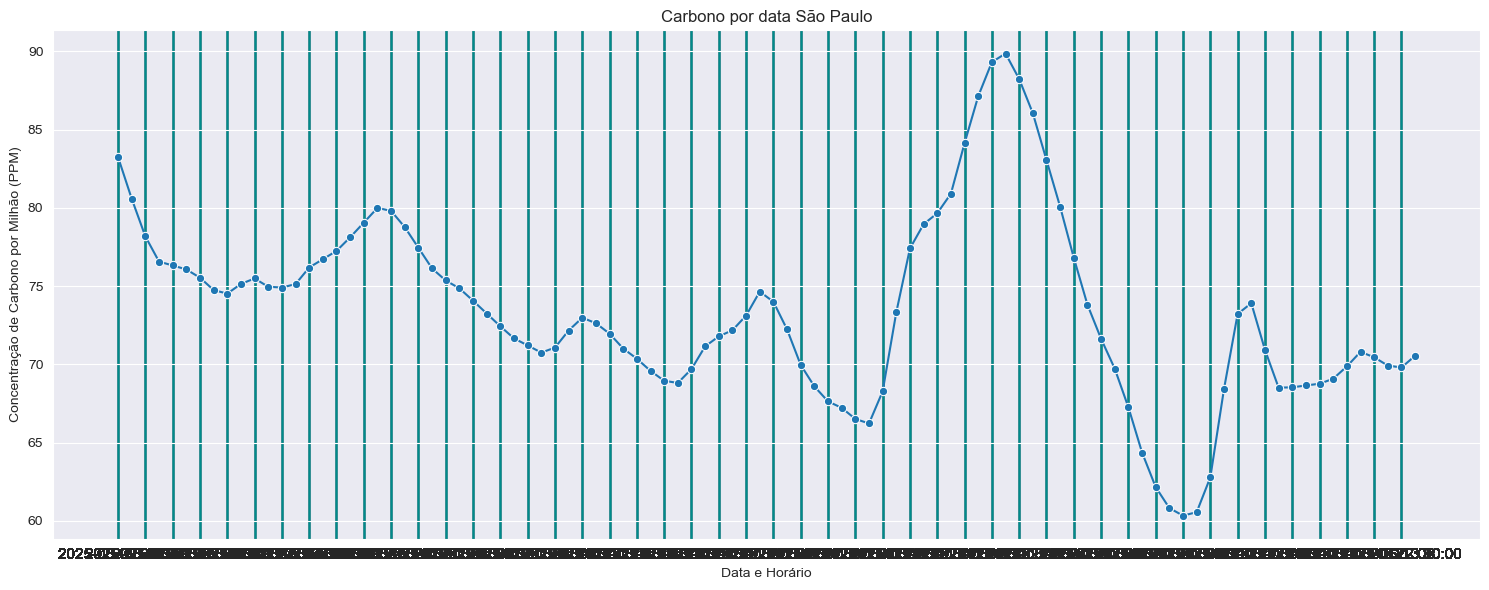

In [26]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
plt.grid(axis='x', linestyle='-', alpha=0.3, color='darkcyan')

sns.lineplot(x='dt', y='co', marker='o', data=df_sp)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.tick_params(axis='x', labelsize=11)

plt.gca().set_xticks(df['dt'][::10])

plt.title('Carbono por data São Paulo')
plt.xlabel('Data e Horário')
plt.ylabel('Concentração de Carbono por Milhão (PPM)')

plt.tight_layout()

plt.show()